# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [51]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, min, max, split, udf, isnan, when, count, desc
from pyspark.sql.functions import sum as Fsum
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator

import re
import plotly 
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# create a Spark session
sc = SparkSession.builder \
    .appName("SparkifyProject") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = sc.read.json('mini_sparkify_event_data.json')

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
print('Structure: {} Rows, {} Columns'.format(df.count(), len(df.columns)))

Structure: 286500 Rows, 18 Columns


In [7]:
# Get null values count
df.select([count(when(col(c).isNull(), c)).alias(c) for c in 
           df.columns]).toPandas().transpose()

,0
artist,58392
auth,0
firstName,8346
gender,8346
itemInSession,0
lastName,8346
length,58392
level,0
location,8346
method,0


In [8]:
df.where(df.userId == '').count()

8346

In [9]:
# Blank users pertain to Logged Out events
df.where(df.userId == '').take(5)

[Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=100, lastName=None, length=None, level='free', location=None, method='GET', page='Home', registration=None, sessionId=8, song=None, status=200, ts=1538355745000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=101, lastName=None, length=None, level='free', location=None, method='GET', page='Help', registration=None, sessionId=8, song=None, status=200, ts=1538355807000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=102, lastName=None, length=None, level='free', location=None, method='GET', page='Home', registration=None, sessionId=8, song=None, status=200, ts=1538355841000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=103, lastName=None, length=None, level='free', location=None, method='PUT', page='Login', registration=None, s

In [5]:
# Drop blank users and sessions
df = df.dropna(how = "any", subset = ["userId", "sessionId"])

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## User exploration 
- How many unique users do we have?
- What is the gender distribution?

## Activity exploration
- What are the most played songs?
- What are the most played artists?

In [11]:
# Create temporary view for data manipulation and exploration usign SQL
df.createOrReplaceTempView("sparkify_data")

In [12]:
sc.sql('select count(*) from sparkify_data a \
join sparkify_data b on a.userId = b.userId').show()

+---------+
| count(1)|
+---------+
|809475444|
+---------+



In [13]:
# How many unique users do we have?
sc.sql('Select count (distinct userId) as Total_Users from sparkify_data').show()

+-----------+
|Total_Users|
+-----------+
|        226|
+-----------+



In [14]:
# What is the gender distribution?
sc.sql('Select gender, count(distinct userId) from sparkify_data \
group by gender').show()

+------+----------------------+
|gender|count(DISTINCT userId)|
+------+----------------------+
|     F|                   104|
|  null|                     1|
|     M|                   121|
+------+----------------------+



In [15]:
sc.sql('select distinct level from sparkify_data').show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

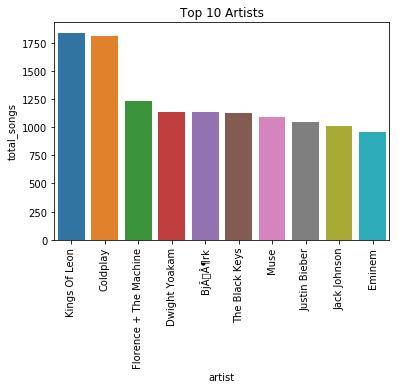

In [40]:
# What are the most played artists
artists = sc.sql('Select artist, count(artist) as total_songs from sparkify_data \
group by artist \
order by total_songs desc \
limit 10').toPandas()

sns.barplot('artist', 'total_songs', data= artists)
plt.title('Top 10 Artists')
plt.xticks(rotation = 90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

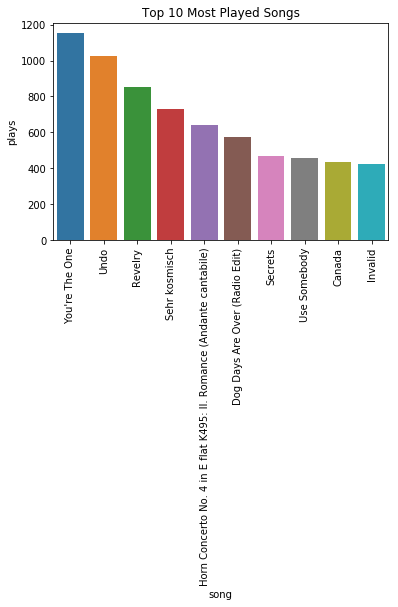

In [41]:
# What are the most played songs?
songs = sc.sql('select song, count(song) as plays from sparkify_data \
group by song \
order by plays desc \
limit 10').toPandas()

sns.barplot('song', 'plays', data= songs)
plt.title('Top 10 Most Played Songs')
plt.xticks(rotation = 90)

In [42]:
df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [ ]:
df.select('length').describe().show()

In [ ]:
activity = df.select('page')\
.groupBy('page')\
.agg({'page': 'count'})\
.sort(desc('count(page)')).withColumnRenamed('count(page)', 'Activity')\
.toPandas()

sns.barplot('page', 'Activity', data= activity, palette = 'BuGn_r')
plt.title('Page by Activity Count')
plt.xticks(rotation = 90)

## Create Churn Variable and Run Refined Exploratory Analysis

In [10]:
churn_flag = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('isChurn', churn_flag('page'))
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("isChurn", Fsum("isChurn").over(windowval))

In [11]:
# Create temporary view for data manipulation and exploration usign SQL
df.createOrReplaceTempView("sparkify_churn_data")

In [12]:
# Total churned users
churn_distribution = sc.sql("Select isChurn, count(distinct userId) as totalUsers from sparkify_churn_data \
group by isChurn").toPandas()

In [13]:
churn_distribution

,isChurn,totalUsers
0,0,174
1,1,52


Text(0.5,1,'Churned Customer Distribution')

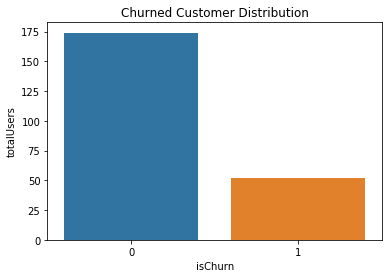

In [46]:
sns.barplot('isChurn', 'totalUsers', data= churn_distribution)
plt.title('Churned Customer Distribution')

## Gender Distribution

In [ ]:
# Gender Distribution by Churn
gender_dist = sc.sql('Select isChurn, gender, count( distinct userId) from sparkify_churn_data \
group by isChurn, gender').withColumnRenamed('count(DISTINCT userId)', 'Volume').toPandas()

In [ ]:
sns.barplot('isChurn', 'Volume', hue = 'gender', data= gender_dist)
plt.title('Churned Customer Distribution by Gender')

## Average Skipped Songs

In [68]:
# Skipped Songs by Churn
skipped_songs = sc.sql("Select isChurn, count(page)/count(distinct userId) avgSkippedSongs from sparkify_churn_data \
where page = 'NextSong' \
group by isChurn").toPandas()

Text(0.5,1,'Avg. Skipped Sogns by Customer Type')

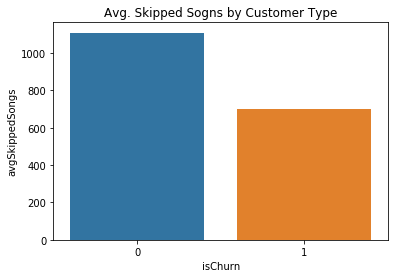

In [133]:
sns.barplot('isChurn', 'avgSkippedSongs', data= skipped_songs)
plt.title('Avg. Skipped Songs by Customer Type')

## Average Sessions

In [70]:
sessions = sc.sql('Select isChurn, count(sessionId)/count(distinct userId) avgSessions from sparkify_churn_data \
group by isChurn').toPandas()

Text(0.5,1,'Avg. Sessions by Customer Type')

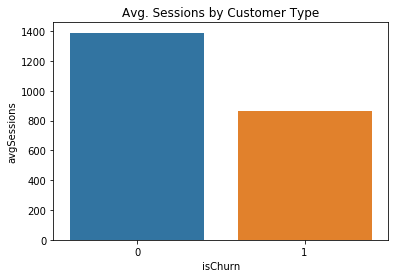

In [134]:
sns.barplot('isChurn', 'avgSessions', data= sessions)
plt.title('Avg. Sessions by Customer Type')

## Average Thumbs Up

In [72]:
# Thumbs Up
thumbs_up = sc.sql("Select isChurn, count(page)/count(distinct userId) avgThumbsUp from sparkify_churn_data \
where page = 'Thumbs Up' \
group by isChurn").toPandas()

Text(0.5,1,'Avg. Thumbs Up by Customer Type')

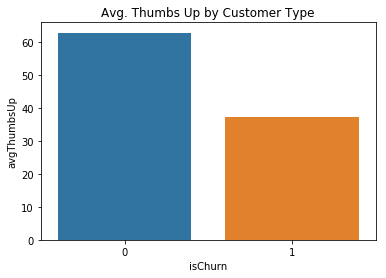

In [135]:
sns.barplot('isChurn', 'avgThumbsUp', data= thumbs_up)
plt.title('Avg. Thumbs Up by Customer Type')

## Average Thumbs Down

In [74]:
# Thumbs Down
thumbs_down = sc.sql("Select isChurn, count(page)/count(distinct userId) avgThumbsDown from sparkify_churn_data \
where page = 'Thumbs Down' \
group by isChurn").toPandas()

Text(0.5,1,'Avg. Thumbs Down by Customer Type')

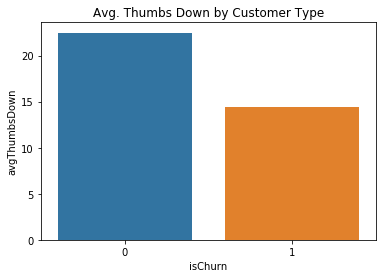

In [136]:
sns.barplot('isChurn', 'avgThumbsDown', data= thumbs_down)
plt.title('Avg. Thumbs Down by Customer Type')

## Average Additions to Playlist

In [76]:
# Thumbs Up
playlist = sc.sql("Select isChurn, count(page)/count(distinct userId) avgPlaylistAdds from sparkify_churn_data \
where page = 'Add to Playlist' \
group by isChurn").toPandas()

Text(0.5,1,'Avg. Playlist Adds by Customer Type')

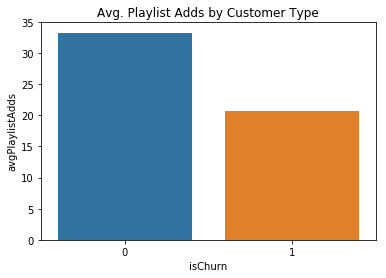

In [137]:
sns.barplot('isChurn', 'avgPlaylistAdds', data= playlist)
plt.title('Avg. Playlist Adds by Customer Type')

## Average Friends Added

In [86]:
# Friends added
friends = sc.sql("Select isChurn, count(page)/count(distinct userId) avgFriends from sparkify_churn_data \
where page = 'Add Friend' \
group by isChurn").toPandas()

Text(0.5,1,'Avg. Friends Added by Customer Type')

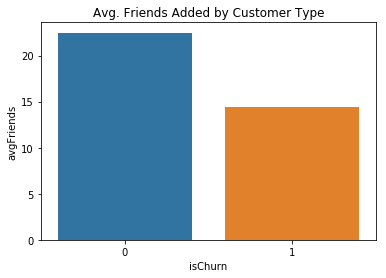

In [138]:
sns.barplot('isChurn', 'avgFriends', data= friends)
plt.title('Avg. Friends Added by Customer Type')

## Average Session Length

In [65]:
sess_length = sc.sql('Select isChurn, (sum(length)/count(distinct sessionId))/3600 avgSessionLength from sparkify_churn_data \
group by isChurn').toPandas()

In [66]:
sess_length

,isChurn,avgSessionLength
0,0,5.813121
1,1,5.370811


Text(0.5,1,'Avg. Session Length in Hours by Customer Type')

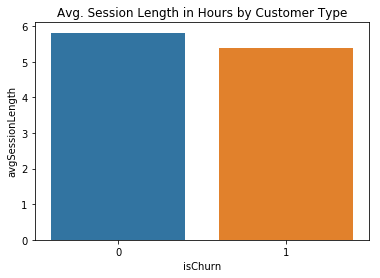

In [68]:
sns.barplot('isChurn', 'avgSessionLength', data= sess_length)
plt.title('Avg. Session Length in Hours by Customer Type')

## Songs

In [106]:
sc.sql('Select isChurn, song, count(song) volume from sparkify_churn_data \
where isChurn = 1 \
group by isChurn, song \
order by volume desc \
limit 20').show()

+-------+--------------------+------+
|isChurn|                song|volume|
+-------+--------------------+------+
|      1|      You're The One|   184|
|      1|                Undo|   155|
|      1|             Revelry|   135|
|      1|       Sehr kosmisch|   126|
|      1|Horn Concerto No....|    99|
|      1|Dog Days Are Over...|    96|
|      1|        Use Somebody|    76|
|      1|             Invalid|    72|
|      1|    Ain't Misbehavin|    70|
|      1|SinceritÃÂ© Et J...|    69|
|      1|              Canada|    67|
|      1|    Somebody To Love|    64|
|      1|       ReprÃÂ©sente|    63|
|      1|             Secrets|    62|
|      1|Catch You Baby (S...|    61|
|      1|          Love Story|    55|
|      1|    Hey_ Soul Sister|    54|
|      1|    Bring Me To Life|    52|
|      1|           Fireflies|    52|
|      1|            The Gift|    52|
+-------+--------------------+------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [14]:
def create_page_features(df):
    
    """ Creates features based on several of the values from the page variable
    
    Args:
    df: Spark Dataframe
    
    Returns:
    page_features: list of Spark Dataframes with page counts
    """
    
    pages = ['Next Song', 'Add Friend', 'Thumbs Up', 'Thumbs Down', 'Add to Playlist']
    renamed_columns = ['skippedSongs', 'friendsAdded', 'thumbsUp', 'thumbsDown', 'playlistAdditions']
    page_features = []
    
    for page, renamed_col in zip(pages , renamed_columns):
        var = df.select('userId', 'page')\
        .groupby('userId', 'page')\
        .agg({'page' : 'count'})\
        .filter(df.page == page)\
        .withColumnRenamed('count(page)', renamed_col)
        page_features.append(var)
        
    return page_features

In [15]:
def create_features(df):
    """ Creates all features for modelling and returns a new dataframe with each unique user as an instance
    Args:
    df: Spark dataframe with raw data
    
    Return:
    engineered_df: Spark dataframe with unique users and their engineered features showcasing user behavior
    """
    
    # Create gender feature
    male_flag = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
    df = df.withColumn('isMale', male_flag('gender'))
    
    # Create page features
    features = create_page_features(df)
    
    # Count total sessions
    sessions = df.select('userId', 'sessionId').\
    groupBy('userId').\
    agg({'sessionId': 'count'}).\
    withColumnRenamed('count(sessionId)', 'totalSessions')
    
    # Sum total Length
    total_length = df.select('userId', 'length').\
    groupBy('userId').\
    agg({'length': 'sum'}).\
    withColumnRenamed('sum(length)', 'totalLength')
    
    # Put all features together
    features.extend([sessions, total_length])
    
    for i in features:
        df = df.join(i, on = ['userId'], how = 'outer')
    
    engineered_df = df.select('userId', 'isChurn', 'isMale', 'thumbsUp', 'thumbsDown', 'playlistAdditions', 
          'totalSessions', 'totalLength', 'friendsAdded', 'skippedSongs').dropDuplicates()

    return engineered_df

In [16]:
new_df = create_features(df)
new_df = new_df.fillna(0)

In [17]:
# https://stackoverflow.com/questions/40337744/scalenormalise-a-column-in-spark-dataframe-pyspark
for i in ['thumbsUp', 'thumbsDown', 'playlistAdditions', 'totalSessions', 'totalLength', 'friendsAdded', 'skippedSongs']:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    new_df = pipeline.fit(new_df).transform(new_df).drop(i+"_Vect")



In [18]:
all_feat_assembler = VectorAssembler(inputCols=['thumbsUp_Scaled', 'thumbsDown_Scaled', 'playlistAdditions_Scaled', 
                                                'totalSessions_Scaled', 'totalLength_Scaled', 'friendsAdded_Scaled', 
                                                'skippedSongs_Scaled','isMale'],outputCol="features")
new_df = all_feat_assembler.transform(new_df)

In [20]:
# features = df.select('userId', 'isChurn', 'isMale', 'thumbsUp', 'thumbsDown', 'playlistAdditions', 
#           'totalSessions', 'totalLength', 'friendsAdded', 'skippedSongs').dropDuplicates()

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [24]:
new_df = new_df.select(new_df['isChurn'].alias('label'),new_df['features'])

In [28]:
train, test = new_df.randomSplit([0.7, 0.3], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 166
Test Dataset Count: 60


In [36]:
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10, regParam=0.01)
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

In [46]:
def classify(model):
    
    """ Takes model and applies it to the dataset to calculate accuracy
    Args:
    model: classification model
    Return:
    f1_score: float value on model's robustness
    """
    
    fitted_model = model.fit(train)
    preds = fitted_model.transform(test)
    evaluator = MulticlassClassificationEvaluator()
    f1_score = evaluator.evaluate(preds,{evaluator.metricName: "f1"})
    
    return f1_score

In [47]:
# Logistic regression results
lr_f1 = classify(lr)

In [48]:
# Random Forest results
rf_f1 = classify(rf)

In [49]:
# SVM results
svm = LinearSVC(maxIter=10, regParam=0.1)
svm_f1 = classify(svm)

In [50]:
print('Logistic Regression F1-Score: {}'.format(round(lr_f1*100,2)))
print('Random Forest F1-Score: {}'.format(round(rf_f1*100,2)))
print('SVM F1-Score: {}'.format(round(rf_f1*100,2)))

Logistic Regression F1-Score: 66.54
Random Forest F1-Score: 66.54
SVM F1-Score: 66.54


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.